<a href="https://colab.research.google.com/github/JayBaileyCS/RLAlgorithms/blob/main/PPO_Atari_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/DLR-RM/stable-baselines3
!pip install gym[atari]
!pip install autorom[accept-rom-license]
!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y
!pip install ale-py==0.7.4 

In [ ]:
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)
from torch.utils.tensorboard import SummaryWriter
import copy
import time
from psutil import virtual_memory

In [ ]:
def make_env(env_id, seed):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk

In [ ]:
def plot_results(steps, rewards, total_timesteps, avg, benchmark):
  plt.plot([item for item in get_rolling_average(steps, avg)], 
          [item for item in get_rolling_average(rewards, avg)])
  max_x = [0, total_timesteps]
  max_y = [benchmark, benchmark] # Cartpole max.
  plt.plot(max_x, max_y, color='r', ls=':')
  plt.xlabel(f"Number of Steps (Avg. {avg})")
  plt.ylabel(f"Current Return (Avg. {avg})")
  plt.show()

def get_rolling_average(items, num):
    rolling = []
    for i in range(len(items)-num):
        rolling.append(sum(items[i:i+num])/num)
    return rolling

def print_colab_info():
  # Print GPU and RAM info for Colab instance.
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

In [ ]:
def layer_init(layer, std=np.sqrt(2), bias=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias)
    return layer

class PPONetworkAtari(nn.Module):
  def __init__(self, envs):
    super(PPONetworkAtari, self).__init__()
    self.network = nn.Sequential(
        layer_init(nn.Conv2d(4, 32, 8, stride=4)),
        nn.ReLU(),
        layer_init(nn.Conv2d(32, 64, 4, stride=2)),
        nn.ReLU(),
        layer_init(nn.Conv2d(64, 64, 3, stride=1)),
        nn.ReLU(),
        nn.Flatten(),
        layer_init(nn.Linear(3136, 512)),
        nn.ReLU()
    )
    self.actor = layer_init(nn.Linear(512, envs.single_action_space.n), std=0.01)
    self.critic = layer_init(nn.Linear(512, 1), std=1)

  def get_value(self, x):
    return self.critic(self.network(x / 255.0)) # Normalise pixel values to range [0, 1].

  def get_action_and_value(self, x, action=None):
    logits = self.actor(self.network(x / 255.0))
    probabilities = Categorical(logits=logits)
    if action is None:
      action = probabilities.sample()
    return action, probabilities.log_prob(action), probabilities.entropy(), self.get_value(x)

In [ ]:
%load_ext tensorboard

def train(env, total_timesteps, num_steps, num_envs, num_minibatches, update_epochs, seed, gamma, gae, learning_rate, value_coefficient, entropy_coefficient, clip, gradient_clip):
  
  envs = gym.vector.SyncVectorEnv([make_env(env, seed+n) for n in range(num_envs)])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  print(device)
  print_colab_info()
  run_name = f"{env}__PPO_From_Scratch__Seed{seed}__{int(time.time())}"

  writer = SummaryWriter(f"runs/test/{run_name}")
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True if seed > 0 else False

  ppo_network = PPONetworkAtari(envs).to(device)
  print(ppo_network)
  optimiser = torch.optim.Adam(ppo_network.parameters(), learning_rate, eps=1e-5)

  episode_end_steps = []
  episode_returns = []
  batch_size = num_steps * num_envs
  minibatch_size = batch_size // num_minibatches
  updates = total_timesteps // batch_size

  obs = torch.zeros((num_steps, num_envs) + envs.single_observation_space.shape).to(device)
  actions = torch.zeros((num_steps, num_envs) + envs.single_action_space.shape).to(device)
  logprobs = torch.zeros((num_steps, num_envs)).to(device)
  rewards = torch.zeros((num_steps, num_envs)).to(device)
  dones = torch.zeros((num_steps, num_envs)).to(device)
  values = torch.zeros((num_steps, num_envs)).to(device)

  next_done = torch.zeros(num_envs).to(device)
  next_obs = torch.Tensor(envs.reset()).to(device)
  start_time = time.time()
  global_step = 0

  for update in range(1, updates+1):
    annealed_learning_rate = learning_rate * (1 - (global_step/total_timesteps))
    optimiser.param_groups[0]["lr"] = annealed_learning_rate
    
    for step in range(num_steps):
      global_step += num_envs
      obs[step] = next_obs
      dones[step] = next_done

      with torch.no_grad():
        action, logprob, _, value = ppo_network.get_action_and_value(next_obs)
        values[step] = value.flatten()

      actions[step] = action
      logprobs[step] = logprob

      next_obs, reward, done, info = envs.step(action.cpu().numpy())
      next_obs = torch.Tensor(next_obs).to(device)
      next_done = torch.Tensor(done).to(device)

      rewards[step] = torch.tensor(reward).to(device).view(-1)

      for item in info:
        if "episode" in item.keys():
          print(f"global_step={global_step}, episodic_return={item['episode']['r']}")
          episode_end_steps.append(global_step)
          episode_returns.append(item['episode']['r'])
          writer.add_scalar("charts/episodic_return", item["episode"]["r"], global_step)
          writer.add_scalar("charts/episodic_length", item["episode"]["l"], global_step)
          break

    with torch.no_grad():
      # Calculate advantage
      next_value = ppo_network.get_value(next_obs).reshape(1, -1)
      advantages = torch.zeros_like(rewards).to(device)
      previous_advantage = 0

      for t in reversed(range(num_steps)):
        next_val = next_value if t == num_steps-1 else values[t+1]
        next_nonterminal = 1.0 - next_done if t == num_steps-1 else 1.0 - dones[t+1]
        delta = rewards[t] + gamma * next_nonterminal * next_val - values[t]
        advantages[t] = delta + gamma * gae * next_nonterminal * previous_advantage
        previous_advantage = advantages[t]

      returns = advantages + values
  
    # Flatten lists
    batch_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    batch_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    batch_logprobs = logprobs.reshape(-1)
    batch_advantages = advantages.reshape(-1)
    batch_returns = returns.reshape(-1)
    batch_values = values.reshape(-1)
    batch_indices = np.arange(batch_size)

    for epoch in range(update_epochs):

        # Shuffle list into minibatches
        np.random.shuffle(batch_indices)
        mb_indices = [[batch_indices[i] for i in range(j*minibatch_size, (j+1)*minibatch_size)] for j in range(num_minibatches)]

        for minibatch in mb_indices:
          minibatch_advantages = batch_advantages[minibatch]

          # Normalise advantages
          minibatch_advantages = ((minibatch_advantages - minibatch_advantages.mean()) / (minibatch_advantages.std() + 1e-8))

          _, new_logprobs, entropy, new_value = ppo_network.get_action_and_value(batch_obs[minibatch], batch_actions.long()[minibatch])
          logratio = new_logprobs - batch_logprobs[minibatch]
          ratio = logratio.exp()

          # Calculate clipped policy loss
          policy_loss = -(ratio * minibatch_advantages)
          clipped_policy_loss = -(torch.clamp(ratio, 1 - clip, 1 + clip) * minibatch_advantages)
          policy_loss = torch.max(policy_loss, clipped_policy_loss).mean()

          # Calculate unclipped value loss
          new_value = new_value.view(-1)
          value_loss = 0.5 * ((new_value - batch_returns[minibatch]) ** 2).mean()

          loss = policy_loss - entropy.mean() * entropy_coefficient + value_loss * value_coefficient

          # Gradient descent
          optimiser.zero_grad()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(ppo_network.parameters(), gradient_clip)
          optimiser.step()

    # Logs
    writer.add_scalar("charts/learning_rate", optimiser.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", value_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", policy_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy.mean().item(), global_step)
    print("SPS:", int(global_step / (time.time() - start_time)))
    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

  envs.close()
  writer.close()
  plot_results(episode_end_steps, episode_returns, total_timesteps, 50, 400)

train(env='BreakoutNoFrameskip-v4', total_timesteps=10000000, num_steps=32, num_envs=8, num_minibatches=4, update_epochs=4, seed=1, gamma=0.99, gae=0.95, learning_rate=2.5e-4, value_coefficient=0.5, entropy_coefficient=0.01, clip=0.1, gradient_clip=0.5)
!tensorboard dev upload --logdir runs/{run_name}

PPO Comparison. CleanRL at the top, this code at the bottom.

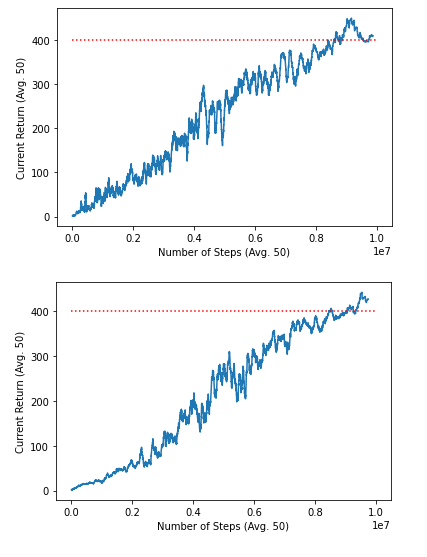